# COMPOSITE - LSTM-Autoencoder & CNN-Autoencoder

Composites are compounds formed by different materials to obtain new properties that those materials alone do not possess. In this case I have worked on the process of creating the fibreglass. These composites are created by injecting the mixture of materials into a mold composed of 32 zones.

![](img/img0.PNG)

The available data is composed of 10,000 csv files (26gb), each corresponding to a process of creating the composite. Each process has variables from different sensors that change over time, captured with a frequency of 0.05-0.1 seconds. These variables represent pressures of the different zones and the injection flow of the compound.

On the other hand, there are also constant columns that measure the final quality of the product. Among them there is a variable that classifies the experiment or process in a binary way, being 1 when the creation process has been carried out correctly and 0 when it has been carried out incorrectly. The other quality measurements have been discarded. We are faced with a binary classification problem. Among the 10,000 experiments, we have 5,000 correct and 5,000 incorrect experiments.

## 1. Problem definition

The main objective of this problem will be to try to detect in a semi-supervised way which experiments are correct and which are not. Assuming that the correct experiments represent correct behavior in a similar way, we will train our model only with these experiments. In this way, we will model normal behavior and be able to detect anything outside of that normality. 

With this, we will define an error threshold. Any instance that is below that error threshold will be considered normal behavior while anything above that threshold will be considered an anomaly.

## 2. Measure of success

To know if the results are correct or not, the accuracy will be taken into account. With this we can know how to measure the success rate of our model.

## 3. Evaluation protocol

Due to the fact that we have 5000 correct and 5000 incorrect experiments, and taking into account the dimensionality of the data, we will divide our data into train and test.On one hand, we will use 4000 correct experiments to train our model and model normality. On the other hand, 1000 correct experiments and 5000 incorrect experiments will be saved for the test stage.

- Training
    - 4000 correct experiments
- Testing
    - 1000 correct experiments
    - 5000 incorrect experiments

## 4. Preparing the data

### Reshape the time series to 832 time-steps

As the length of the experiments is not fixed, we will reduce all the experiments so that they have the same duration as the shortest experiment. In the case of these data, the shortest experiment has 832 observations. We will use the 'resample' function of the Scipy library to reduce the dimensionality of the time series.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html

In [1]:
min_samples = 832

In [2]:
import numpy as np
import pandas as pd
from glob import glob
from scipy import signal

size = 832
files = glob('Z:\Descargas\composite\CSV_DATA\*.csv')
for file in files:
    df = pd.read_csv(file)
    col_names = ('Flow rate', 'Pressure')    
    cols = [col for col in df if col.endswith(col_names)]    
    resampled_df = pd.DataFrame(signal.resample(df[cols], min_samples), columns=cols)
    resampled_df['TOTAL_QUALITY'] = df['TOTAL_QUALITY']
    resampled_df.to_csv(file.replace('CSV_DATA', 'deepl\CSV_DATA_RESAMPLED'), index=False)

### Divide the data to train/test

- Training
    - 4000 correct experiments
- Testing
    - 1000 correct experiments
    - 5000 incorrect experiments
    
We concentrate the experiments one below the other, divide them into train/test and export them to csv files.

![](img/img1.PNG)

In [1]:
import numpy as np
import pandas as pd
from glob import glob

files = glob('Z:\Descargas\composite\deepl\CSV_DATA_RESAMPLED\*.csv')

correct = []
incorrect = []

for file in files:
    df = pd.read_csv(file)
    if df.iloc[:,-1][0] == 1:
        correct.append(df)
    else:
        incorrect.append(df)
        
print(len(correct))
print(len(incorrect))

5055
4959


In [9]:
import random

random.shuffle(correct)
random.shuffle(incorrect)

train_correct = correct[:4000]
train_correct = pd.concat(train_correct)
train_correct = train_correct.to_csv('Z:\\Descargas\\composite\\deepl\\train_correct.csv', index=False)

test_correct = correct[-1055:]
test_correct = pd.concat(test_correct)
test_correct = test_correct.to_csv('Z:\\Descargas\\composite\\deepl\\test_correct.csv', index=False)

test_incorrect = incorrect
test_incorrect = pd.concat(test_incorrect)
test_incorrect = test_incorrect.to_csv('Z:\\Descargas\\composite\\deepl\\test_incorrect.csv', index=False)

### Normalize the data using MinMaxScaler

We normalize our data with the Sklearn MinMaxScaler function. With this we get our data in a range between 0 and 1. This scaler is only trained with the train data and will be used to normalize the test data.

In [1]:
import pandas as pd

train = pd.read_csv('Z:\\Descargas\\composite\\deepl\\train_correct.csv')
train = train.drop('TOTAL_QUALITY', axis=1)
train.shape

(3328000, 29)

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(train)
train = scaler.transform(train)
train.shape

(3328000, 29)

### Reshape the data

Reshape the data so that the dimensions are suitable for our recurrent model.

- samples = 4000
- timesteps = 832
- features = 29

In [3]:
# reshape input into [samples, timesteps, features]

train = train.reshape((4000, 832, 29))
train.shape

(4000, 832, 29)

## 5. Developing the LSTM-Autoencoder model

In [4]:
# https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network
# https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/

In [5]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1, l2

model = models.Sequential([
    layers.LSTM(128, activation='relu', kernel_regularizer=l1(0.001), return_sequences=True, input_shape=(832, 29)),
    layers.LSTM(64, activation='relu', kernel_regularizer=l1(0.001), return_sequences=False),
    layers.RepeatVector(train.shape[1]),
    layers.LSTM(64, activation='relu', kernel_regularizer=l1(0.001), return_sequences=True),
    layers.LSTM(128, activation='relu', kernel_regularizer=l1(0.001), return_sequences=True),
    layers.TimeDistributed(layers.Dense(train.shape[2]))
])

#opt = SGD(lr=0.01, momentum=0.9, nesterov=True, clipnorm=1)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 832, 128)          80896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 832, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 832, 64)           33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 832, 128)          98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 832, 29)           3741      
Total params: 265,885
Trainable params: 265,885
Non-trainable params: 0
__________________________________________________

In [6]:
early_stop = [EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None)]

history = model.fit(train, train, callbacks=early_stop, epochs=20, batch_size=128, validation_split=0.1)

Train on 3600 samples, validate on 400 samples
Epoch 1/20
3600/3600 [==============================] - 57s 16ms/sample - loss: 4.4421 - val_loss: 3.2100
Epoch 2/20
3600/3600 [==============================] - 51s 14ms/sample - loss: 2.3400 - val_loss: 1.4754
Epoch 3/20
3600/3600 [==============================] - 51s 14ms/sample - loss: 0.9328 - val_loss: 0.4434
Epoch 4/20
3600/3600 [==============================] - 51s 14ms/sample - loss: 0.2258 - val_loss: 0.0703
Epoch 5/20
3600/3600 [==============================] - 51s 14ms/sample - loss: 0.0355 - val_loss: 0.0181
Epoch 6/20
3600/3600 [==============================] - 51s 14ms/sample - loss: 0.0145 - val_loss: 0.0127
Epoch 7/20
3600/3600 [==============================] - 51s 14ms/sample - loss: 0.0124 - val_loss: 0.0122
Epoch 8/20
3600/3600 [==============================] - 52s 14ms/sample - loss: 0.0122 - val_loss: 0.0122
Epoch 9/20
3600/3600 [==============================] - 51s 14ms/sample - loss: 0.0122 - val_loss: 0.0122

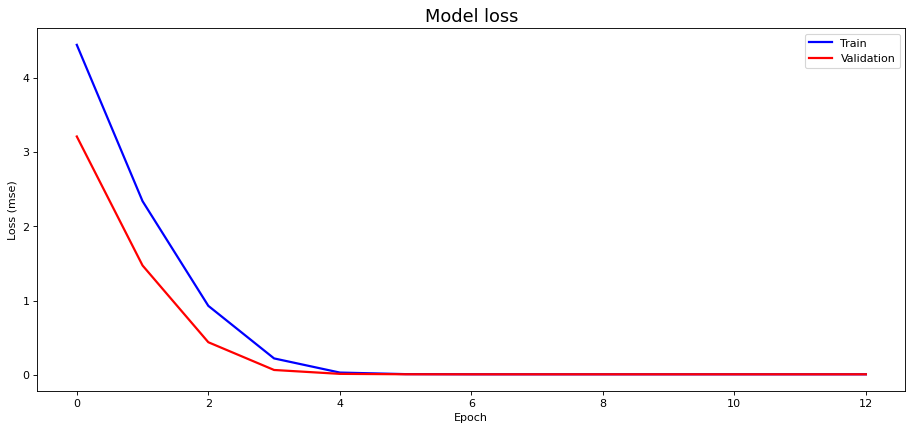

In [7]:
from matplotlib import pyplot as plt

# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [8]:
model.save('models/lstm_autoencoder_model.h5') 

### Model validation

In [9]:
from tensorflow.keras.models import load_model

model = load_model('models/lstm_autoencoder_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 832, 128)          80896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 832, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 832, 64)           33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 832, 128)          98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 832, 29)           3741      
Total params: 265,885
Trainable params: 265,885
Non-trainable params: 0
__________________________________________________

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# load
train = pd.read_csv('Z:\\Descargas\\composite\\deepl\\train_correct.csv')
train = train.drop('TOTAL_QUALITY', axis=1)
test_incorrect = pd.read_csv('Z:\\Descargas\\composite\\deepl\\test_incorrect.csv')
test_incorrect = test_incorrect.drop('TOTAL_QUALITY', axis=1)

# normalize
scaler = MinMaxScaler().fit(train)
train = scaler.transform(train)
test_incorrect = scaler.transform(test_incorrect)

# reshape
train = train.reshape((4000, 832, 29))
test_incorrect = test_incorrect.reshape((4959, 832, 29))

# predict
pred_train = model.predict(train)
pred_test = model.predict(test_incorrect)
print(pred_train.shape)
print(pred_test.shape)

(4000, 832, 29)
(4959, 832, 29)


In [11]:
from sklearn.metrics import mean_absolute_error

errors_train = []

for i in range(0, pred_train.shape[0]):
    error = mean_absolute_error(train[i], pred_train[i])
    errors_train.append(error)

errors_train = np.array(errors_train)
threshold = errors_train.mean()+3*errors_train.std()
threshold

0.000780401788055559

In [12]:
from sklearn.metrics import mean_absolute_error

errors_test = []

for i in range(0, pred_test.shape[0]):
    error = mean_absolute_error(test_incorrect[i], pred_test[i])
    errors_test.append(error)

errors_test = np.array(errors_test)

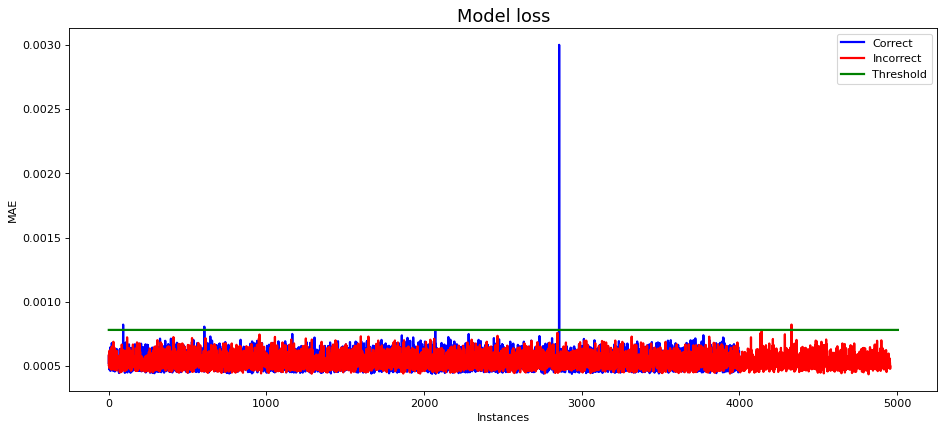

In [13]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(errors_train, 'b', label='Correct', linewidth=2)
ax.plot(errors_test, 'r', label='Incorrect', linewidth=2)
ax.plot(np.full(shape=5007, fill_value=threshold), 'g', label='Threshold', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('MAE')
ax.set_xlabel('Instances')
ax.legend(loc='upper right')
plt.show()

## 6. Developing the CNN-Autoencoder model

In [14]:
from tensorflow.keras import models, layers

model = models.Sequential([
    # encoder
    layers.Conv1D(32, 3, activation='relu', padding='same', input_shape=(832, 29)),   
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(16, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(4, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    # decoder
    layers.Conv1D(4, 3, activation='relu', padding='same'),
    layers.UpSampling1D(2),
    layers.Conv1D(16, 3, activation='relu', padding='same'),
    layers.UpSampling1D(2),    
    layers.Conv1D(32, 3, activation='relu', padding='same'),
    layers.UpSampling1D(2),  
    layers.Conv1D(29, 3, activation='relu', padding='same'),
])

model.compile(optimizer='rmsprop', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 832, 32)           2816      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 416, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 416, 16)           1552      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 208, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 208, 4)            196       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 104, 4)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 104, 4)           

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = [EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None)]

history = model.fit(train, train, callbacks=early_stop, epochs=10, batch_size=64, validation_split=0.1)

Train on 3600 samples, validate on 400 samples
Epoch 1/10
3600/3600 [==============================] - 9s 2ms/sample - loss: 0.0222 - val_loss: 0.0142
Epoch 2/10
3600/3600 [==============================] - 1s 300us/sample - loss: 0.0162 - val_loss: 0.0176
Epoch 3/10
3600/3600 [==============================] - 1s 299us/sample - loss: 0.0156 - val_loss: 0.0121
Epoch 4/10
3600/3600 [==============================] - 1s 301us/sample - loss: 0.0126 - val_loss: 0.0131
Epoch 5/10
3600/3600 [==============================] - 1s 299us/sample - loss: 0.0124 - val_loss: 0.0117
Epoch 6/10
3600/3600 [==============================] - 1s 308us/sample - loss: 0.0105 - val_loss: 0.0077
Epoch 7/10
3600/3600 [==============================] - 1s 304us/sample - loss: 0.0072 - val_loss: 0.0067
Epoch 8/10
3600/3600 [==============================] - 1s 300us/sample - loss: 0.0071 - val_loss: 0.0074
Epoch 9/10
3600/3600 [==============================] - 1s 299us/sample - loss: 0.0070 - val_loss: 0.0069
E

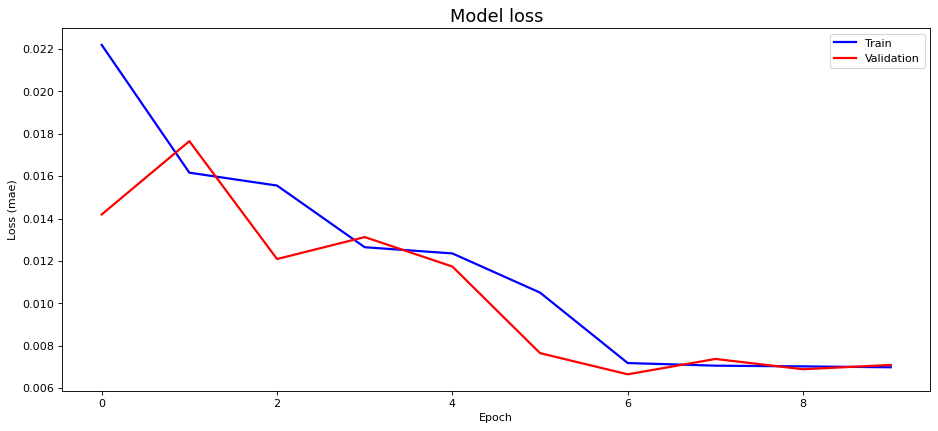

In [16]:
from matplotlib import pyplot as plt

# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [17]:
model.save('models/cnn_autoencoder_model.h5') 

### Model evaluation

In [18]:
import numpy as np
import pandas as pd

test = pd.read_csv('Z:\\Descargas\\composite\\deepl\\test_incorrect.csv')
test = test.drop('TOTAL_QUALITY', axis=1)
test = scaler.transform(test)
test = test.reshape((4959, 832, 29))

pred_train = model.predict(train)
pred_test = model.predict(test)

In [19]:
from sklearn.metrics import mean_absolute_error

errors_train = []

for i in range(0, pred_train.shape[0]):
    error = mean_absolute_error(train[i], pred_train[i])
    errors_train.append(error)

errors_train = np.array(errors_train)
threshold = errors_train.mean()+3*errors_train.std()
threshold

0.007368063236450329

In [20]:
from sklearn.metrics import mean_absolute_error

errors_test = []

for i in range(0, pred_test.shape[0]):
    error = mean_absolute_error(test[i], pred_test[i])
    errors_test.append(error)

errors_test = np.array(errors_test)

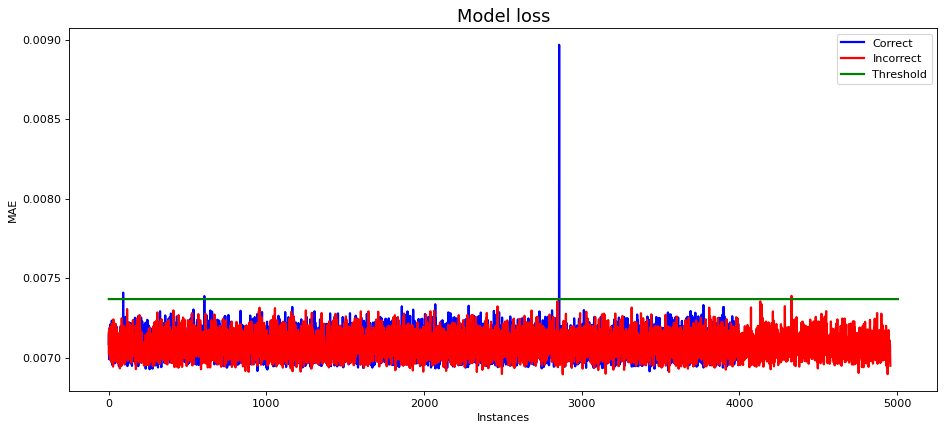

In [21]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(errors_train, 'b', label='Correct', linewidth=2)
ax.plot(errors_test, 'r', label='Incorrect', linewidth=2)
ax.plot(np.full(shape=5007, fill_value=threshold), 'g', label='Threshold', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('MAE')
ax.set_xlabel('Instances')
ax.legend(loc='upper right')
plt.show()